# Modeling Part 2. Multivariate Time Series Analysis.

## Table of Contents
- [Importing Necessary Libraries & Loading Data](#Importing-Necessary-Libraries-&-Loading-Dsta)
- [Modeling](#Modeling)

## Importing Necessary Libraries & Loading Data

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm


from datetime import datetime

import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pmdarima as pm

# This will allow us to avoid a FutureWarning when plotting.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from warnings import catch_warnings
from warnings import filterwarnings
import warnings

warnings.simplefilter(action="ignore")

In [2]:
data = pd.read_csv('../Data/Data_concat_clean.csv')
data.head()

,DATE,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN,...,MN_TMIN_lag_1,IA_TMIN_lag_360,IL_TMIN_lag_360,MN_TMIN_lag_360,IA_TMAX_lag_1,IL_TMAX_lag_1,MN_TMAX_lag_1,IA_TMAX_lag_360,IL_TMAX_lag_360,MN_TMAX_lag_360
0,1990-01-02,0.00,0.00,0.0,49.0,45.0,27.0,28.0,25.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-01-03,0.00,0.00,0.0,45.0,49.0,32.0,35.0,32.0,19.0,...,1.0,NaN,NaN,NaN,49.0,45.0,27.0,NaN,NaN,NaN
2,1990-01-04,0.94,0.05,0.0,42.0,47.0,26.0,21.0,32.0,1.0,...,19.0,NaN,NaN,NaN,45.0,49.0,32.0,NaN,NaN,NaN
3,1990-01-05,0.00,0.00,0.0,40.0,38.0,20.0,18.0,16.0,11.0,...,1.0,NaN,NaN,NaN,42.0,47.0,26.0,NaN,NaN,NaN
4,1990-01-08,0.00,0.00,0.0,43.0,50.0,40.0,31.0,21.0,16.0,...,11.0,NaN,NaN,NaN,40.0,38.0,20.0,NaN,NaN,NaN


Converting 'DATE' column to datetime format, setting it as the index, and sorting the dataframe ascending by date. 

In [3]:
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data.sort_index(inplace=True)
data

,IA_PRCP,IL_PRCP,MN_PRCP,TMAX_IA,TMAX_IL,TMAX_MN,TMIN_IA,TMIN_IL,TMIN_MN,Settlement Price,...,MN_TMIN_lag_1,IA_TMIN_lag_360,IL_TMIN_lag_360,MN_TMIN_lag_360,IA_TMAX_lag_1,IL_TMAX_lag_1,MN_TMAX_lag_1,IA_TMAX_lag_360,IL_TMAX_lag_360,MN_TMAX_lag_360
DATE,,,,,,,,,,,,,,,,,,,,,
1990-01-02,0.00,0.00,0.00,49.0,45.0,27.0,28.0,25.0,1.0,5.613,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,0.00,0.00,0.00,45.0,49.0,32.0,35.0,32.0,19.0,5.673,...,1.0,NaN,NaN,NaN,49.0,45.0,27.0,NaN,NaN,NaN
1990-01-04,0.94,0.05,0.00,42.0,47.0,26.0,21.0,32.0,1.0,5.633,...,19.0,NaN,NaN,NaN,45.0,49.0,32.0,NaN,NaN,NaN
1990-01-05,0.00,0.00,0.00,40.0,38.0,20.0,18.0,16.0,11.0,5.645,...,1.0,NaN,NaN,NaN,42.0,47.0,26.0,NaN,NaN,NaN
1990-01-08,0.00,0.00,0.00,43.0,50.0,40.0,31.0,21.0,16.0,5.707,...,11.0,NaN,NaN,NaN,40.0,38.0,20.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,0.00,0.00,0.00,53.0,57.0,32.0,27.0,26.0,22.0,9.365,...,19.0,67.0,67.0,62.0,45.0,56.0,35.0,86.0,96.0,68.0
2019-12-26,0.00,0.01,0.01,62.0,68.0,33.0,32.0,46.0,22.0,9.465,...,22.0,62.0,68.0,63.0,53.0,57.0,32.0,78.0,86.0,80.0
2019-12-27,0.00,0.00,0.02,37.0,48.0,25.0,32.0,39.0,20.0,9.415,...,22.0,65.0,60.0,58.0,62.0,68.0,33.0,84.0,89.0,79.0


Checking the variable datatypes to ensure all are of type float.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7559 entries, 1990-01-02 to 2019-12-31
Data columns (total 25 columns):
IA_PRCP             7559 non-null float64
IL_PRCP             7559 non-null float64
MN_PRCP             7559 non-null float64
TMAX_IA             7559 non-null float64
TMAX_IL             7559 non-null float64
TMAX_MN             7559 non-null float64
TMIN_IA             7559 non-null float64
TMIN_IL             7559 non-null float64
TMIN_MN             7559 non-null float64
Settlement Price    7559 non-null float64
IA_prcp_lag_1       7558 non-null float64
IL_prcp_lag_1       7558 non-null float64
MN_prcp_lag_1       7558 non-null float64
IA_TMIN_lag_1       7558 non-null float64
IL_TMIN_lag_1       7558 non-null float64
MN_TMIN_lag_1       7558 non-null float64
IA_TMIN_lag_360     7199 non-null float64
IL_TMIN_lag_360     7199 non-null float64
MN_TMIN_lag_360     7199 non-null float64
IA_TMAX_lag_1       7558 non-null float64
IL_TMAX_lag_1       7558 non-null f

Checking the nulls.

In [5]:
data.isnull().sum().sort_values(ascending=False)

MN_TMAX_lag_360     360
IA_TMAX_lag_360     360
IL_TMAX_lag_360     360
MN_TMIN_lag_360     360
IL_TMIN_lag_360     360
IA_TMIN_lag_360     360
IL_TMIN_lag_1         1
IA_prcp_lag_1         1
IL_prcp_lag_1         1
IA_TMIN_lag_1         1
MN_prcp_lag_1         1
MN_TMIN_lag_1         1
IA_TMAX_lag_1         1
IL_TMAX_lag_1         1
MN_TMAX_lag_1         1
Settlement Price      0
TMIN_MN               0
TMIN_IL               0
TMIN_IA               0
TMAX_MN               0
TMAX_IL               0
TMAX_IA               0
MN_PRCP               0
IL_PRCP               0
IA_PRCP               0
dtype: int64

All null values in the dataframe are due to time lags (i.e. annual lags have 360 null values and daily lags only have 1). We do not need to remove these nulls, as we will drop them during the modeling process.

## Modeling



In this model, we are incorporating exogenous features into the SARIMA model we built in the [Modeling Part 1: Univariate Time Series Analysis](https://github.com/AndreaYoss/Capstone/blob/master/EDA/Modeling%20Part%201.%20Univariate%20Time%20Series%20Analysis..ipynb) notebook. We are building a SARIMAX model.
  
To start, we are seperating our dataframe into training and testing data. While we will have the same endogenous feature as our prior models ('Settlement Price'), we will also be including some likely external, exogenous features.  

In [6]:
train_ex = data[data.index<'2017-01-01'].drop(columns = ['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN']).dropna()
test_ex = data[data.index>='2017-01-01'].drop(columns = ['IA_PRCP', 'IL_PRCP', 'MN_PRCP', 'TMAX_IA', 'TMAX_IL', 'TMAX_MN',
       'TMIN_IA', 'TMIN_IL', 'TMIN_MN']).dropna()

In [7]:
sarimax = SARIMAX(endog = train_ex['Settlement Price'],
                order = (4,1,4),
                 seasonal_order = (1,0,0,72),
                 exog = train_ex.drop(columns=['Settlement Price']))

#fit SARIMAX model
model = sarimax.fit()

In [8]:
preds = model.forecast(len(test_ex), 
               exog = test_ex.drop(columns = ['Settlement Price']),
               step=1, 
               alpha = 0.05)
        
#evaluate predictions
print(mean_absolute_error(test_ex['Settlement Price'], preds))

0.7659543850440298


In [9]:
preds.index = test_ex.index

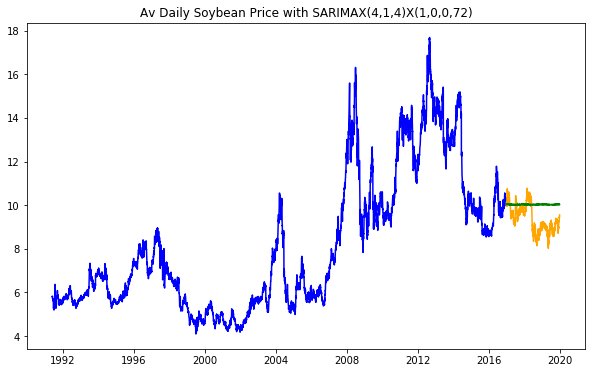

In [10]:
#plot data
plt.figure(figsize = (10,6))
plt.plot(train_ex['Settlement Price'], color = 'blue')
plt.plot(test_ex['Settlement Price'], color = 'orange')
plt.plot(preds, color = 'green')
plt.title(label = 'Av Daily Soybean Price with SARIMAX(4,1,4)X(1,0,0,72)')
plt.show();

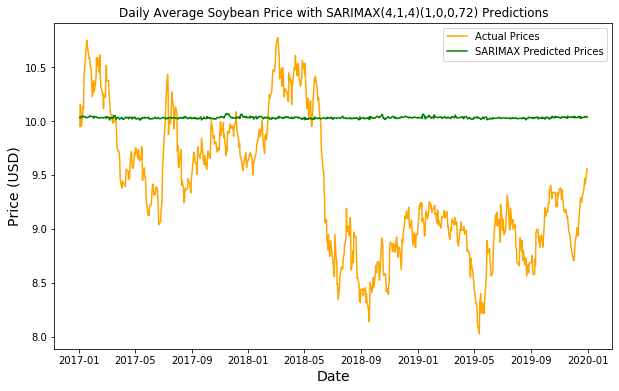

In [15]:
# Plot data.
plt.figure(figsize=(10,6))
plt.plot(test_ex['Settlement Price'], color = 'orange', label = 'Actual Prices')
plt.plot(preds, color = 'green', label = 'SARIMAX Predicted Prices')
plt.title(label = 'Daily Average Soybean Price with SARIMAX(4,1,4)(1,0,0,72) Predictions')

# Plot Approx China Trade War Speculation 
#plt.axvline('2018-06', color = 'r', ls = '-.', label = 'China Trade War Speculation (Approx.)')

plt.ylabel('Price (USD)', fontsize = 14)
plt.xlabel('Date', fontsize = 14)
plt.legend()
plt.show();